In [1]:
from sklearn.cluster import KMeans
import numpy as np
import warnings
import copy
import os
import pandas as pd
warnings.filterwarnings("ignore")
import sys
sys.path.append('../induction_motor_anomaly_detection/')
import modules,scaler

In [2]:
normal_data = pd.read_csv('../data/combined_data.csv')
anomalous_data = pd.read_csv('../anomalous_data/anomalous_data.csv')


In [4]:
train_data_features = modules.ElectricalFeatureExtractor(current_data=normal_data)
test_data_features = modules.ElectricalFeatureExtractor(current_data=anomalous_data)
train_scaler = scaler.Scaler()
train_scaler.fit_unlabelled_data(train_data_features.feature_dataframe[0])
train_scaled = train_scaler.transform(train_data_features.feature_dataframe[0])
test_scaled = train_scaler.transform(test_data_features.feature_dataframe[0])

In [3]:

class AnomalyDetector:
    def __init__(self, n_clusters=8, k_threshold_std_dev=3):
        self.n_clusters = n_clusters
        self.k_threshold_std_dev = k_threshold_std_dev
        self.kmeans = None
        self.X = np.array([])

    def fit(self, X):
        """
        Fit the k-means clustering to the training data.
        """
        if self.kmeans is None:
            self.kmeans = KMeans(n_clusters=self.n_clusters)
            self.kmeans.fit(X)
            self.X = X
        else:
            self.X = np.concatenate((self.X, X), axis=0)
            self.kmeans = KMeans(n_clusters=self.n_clusters, init=self.kmeans.cluster_centers_)
            self.kmeans.fit(self.X)

    def predict(self, X_test):
        """
        Predict whether the data is anomalous or not based on the k-means clustering.
        """
        distances = self.kmeans.transform(X_test)
        centroid_distances = np.min(distances, axis=1)
        mean_distance = np.mean(centroid_distances)
        std_distance = np.std(centroid_distances)
        threshold = mean_distance + self.k_threshold_std_dev * std_distance
        is_anomaly = centroid_distances > threshold
        return is_anomaly


In [17]:
anomaly_detector = AnomalyDetector(n_clusters=7, k_threshold_std_dev=3)

it = iter(train_scaled)
try:
    while True:
        if anomaly_detector.kmeans is None:
            data = [next(it), next(it),next(it),next(it),next(it),next(it),next(it)] #if the model is being fit for the first time
        else :
            data = [next(it)]
        anomaly_detector.fit(data)
        anomaly_predictions = anomaly_detector.predict(data)
        if any(anomaly_predictions):
            print('anomalous')
            print(anomaly_predictions)
        else:
            # print('not anomalous')
            pass
except StopIteration:
    pass


In [18]:
anomaly_scores = anomaly_detector.predict(train_scaled)
np.where(anomaly_scores == 1)[0]


array([232, 235, 242], dtype=int64)

In [19]:
anomaly_detector.predict(test_scaled)


array([False])

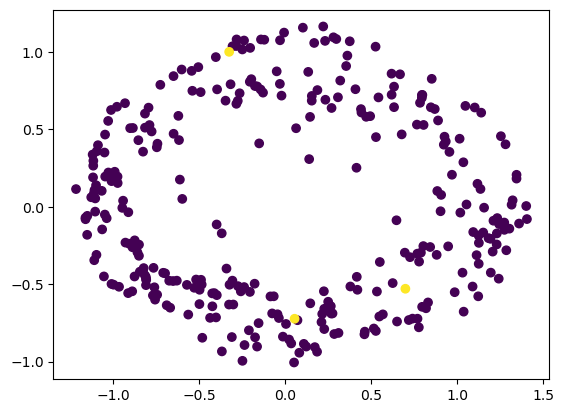

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# assuming you have already scaled and preprocessed the data and stored it in variable X

pca = PCA(n_components=2)
X_2d = pca.fit_transform(train_scaled)

# assuming you have already fit the anomaly detection model and stored it in variable anomaly_detector
anomaly_predictions = anomaly_detector.predict(train_scaled)

# scatter plot of the data points colored by anomaly label
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=anomaly_predictions)
plt.show()

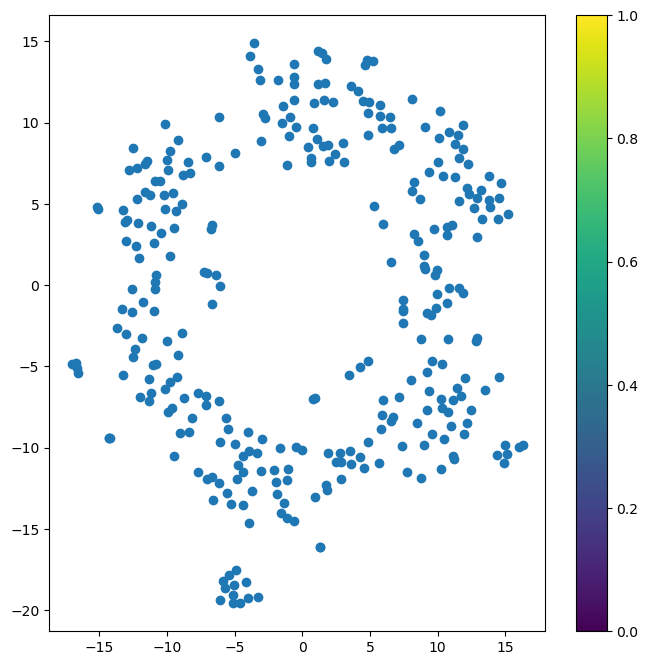

In [22]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(train_scaled)

# Visualize the clusters using a scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], cmap='viridis')
plt.colorbar()
plt.show()


There could be several reasons why k-means might not perform as well as Isolation Forest or GMM in detecting anomalies:

Sensitivity to initialization: k-means is sensitive to the initial placement of the cluster centers. If the initial centers are chosen poorly, the algorithm may converge to a suboptimal solution that does not capture the underlying structure of the data. This sensitivity can be mitigated by using techniques such as k-means++ initialization or multiple random initializations, but it may still be a limiting factor.

Sensitivity to the number of clusters: k-means requires the number of clusters to be specified in advance. If the number of clusters is set too low, the algorithm may not be able to capture the underlying structure of the data. If the number of clusters is set too high, the algorithm may overfit the data and identify clusters that do not correspond to meaningful patterns.

Assumption of spherical clusters: k-means assumes that the clusters are spherical and have equal variance. If the clusters in the data are not spherical or have different variances, k-means may not be able to capture their shape accurately.

Sensitivity to outliers: k-means is sensitive to outliers, as they can pull the cluster centers away from the true center of the data. This can make it more difficult for the algorithm to identify the underlying structure of the data.

In contrast, Isolation Forest and GMM are less sensitive to these factors and can often perform better in detecting anomalies. Isolation Forest is based on random trees and does not make assumptions about the shape or distribution of the data. GMM can capture more complex distributions than k-means, and can adjust the number of clusters based on the data.